### Imports

In [1]:
#!/usr/bin/env python3

from functools import wraps
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randn, rand
import numdifftools as nd
import picos as pc
from scipy.integrate import solve_ivp
from scipy.io import loadmat
import time

plt.style.use("default")

### Runtime

In [2]:
def runtime(func):
    @wraps(func)
    def runtime_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print("\n", f'Function {func.__name__} took {total_time:.4f} seconds')
        return result
    return runtime_wrapper

### Read data

In [3]:
#name_of_dataset = 'Angle'
name_of_dataset = 'CShape'
#name_of_dataset = 'Sshape'

dataset = loadmat("Dataset/" + name_of_dataset + '.mat')
# Unpack the trajectories and place into x and y used in learning step
num_of_demos = dataset['demos'].shape[1]
size_of_state = dataset['demos'][0, 0][0,0][0].shape[0]
dim_of_function = size_of_state 

#### Mean of dataset

In [4]:
num_of_train_datasets = 4
num_of_points = len(dataset['demos'][0,0][0,0][0][0])

pos_cell_1 = np.zeros((num_of_points, num_of_train_datasets))
pos_cell_2 = np.zeros((num_of_points, num_of_train_datasets))
vel_cell_1 = np.zeros((num_of_points, num_of_train_datasets))
vel_cell_2 = np.zeros((num_of_points, num_of_train_datasets))

# Concatenating the dataseries of position and velocities
for i in range(0, num_of_train_datasets):
    demo_struct = dataset['demos'][0,i][0,0]

    position_dataseries = dataset['demos'][0,i][0,0][0]
    velocity_dataseries = dataset['demos'][0,i][0,0][2]

    pos_cell_1[:, i] = position_dataseries[0]
    pos_cell_2[:, i] = position_dataseries[1]
    vel_cell_1[:, i] = velocity_dataseries[0]
    vel_cell_2[:, i] = velocity_dataseries[1]

x_train_1 = pos_cell_1.mean(axis=1)
x_train_2 = pos_cell_2.mean(axis=1)
y_train_1 = vel_cell_1.mean(axis=1)
y_train_2 = vel_cell_2.mean(axis=1)

# Defines the position and velocity measurements
x_train = np.array([x_train_1, x_train_2])
y_train = np.array([y_train_1, y_train_2])

# Get time info for simulating the learnt system later
time_step = dataset['dt'][0,0]

len_of_dataseries = dataset['demos'][0, 0][0,0][0].shape[1] 

concatenate = np.concatenate((np.array([[0]]), time_step * np.ones((1, len_of_dataseries - 1))),axis=1)
time_series = np.cumsum(concatenate)
num_of_timesteps = len_of_dataseries
num_of_test_datasets = num_of_demos - num_of_train_datasets

# Intial starting point for the simulated trajectory using learnt model
init_condition = dataset['demos'][0,5][0,0][0][:, 0]

#### Plot dataset (state trajectory with velocities as arrows)

C:\Users\vilde\AppData\Local\Temp\ipykernel_24544\1901655976.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_dataset.show()


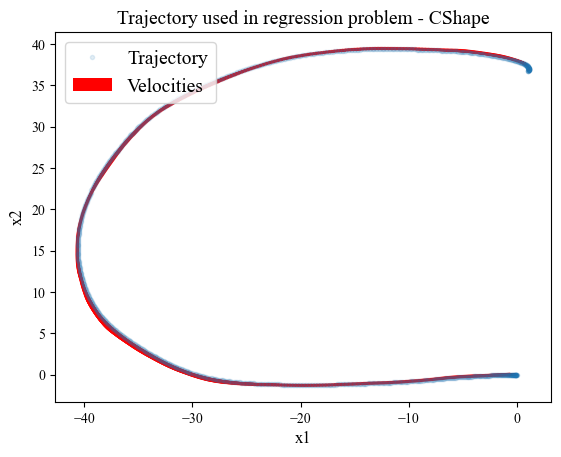

In [5]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": "Times New Roman",
})

fig_dataset = plt.figure(1)
plt.title('Trajectory used in regression problem - ' + name_of_dataset, fontsize=14)
plt.plot(x_train[0,:], x_train[1,:], '.', alpha = 0.12)
plt.quiver(x_train[0,:], x_train[1,:], y_train[0,:], y_train[1,:], color = 'red', scale = 700)
plt.xlabel('x1', fontsize =12)
plt.ylabel('x2', fontsize=12)
plt.legend(['Trajectory', 'Velocities'], loc = "upper left" , frameon = True , prop ={'size': 14 } )
fig_dataset.show()
#plt.savefig("../src/figures_plot/lasa_datatset.eps", format ="eps")

axes = plt.gca() #gca = get current axes, from my last plot

### Vector-valued RFF for curl-free kernel

#### Variables

In [6]:
sigma = 10
lambda_ = 0.1
num_of_constraint_points = 250
num_of_samples = 100

w = randn(size_of_state, num_of_samples)/sigma
b = rand(1,num_of_samples)*2*np.pi
mu = 0.0

#### Functions

In [7]:
def psi_curl_free(x, w, b):
    return np.sqrt(2) * np.sin(w.T@x+b)*w.T

def capital_psi_cf(x, w, b, d, dim):
    psi_vector_cf = np.zeros((d, dim)) # (100,2)
    #([x1,y1],[x2,y2], ..., [x200,y200])
    for i in range(d):
        psi_element = psi_curl_free(x, w[:,i], b[:,i])
        psi_vector_cf[i] = psi_element
    return np.array(psi_vector_cf).T

def phi_function_cf(x, w, b, N, d, dim):
    #([x1,y1],[x2,y2], ..., [x200,y200])
    phi = np.zeros((dim*N, d)) #(2,100)
    psi_cf = capital_psi_cf(x, w, b, d, dim) #(2,100)
    phi[dim*0] = psi_cf[0]
    phi[dim*0+1] = psi_cf[1]
    return phi

def capital_psi_z_function_cf(x, w, b, d, dim, L):
    psi = capital_psi_cf(x, w, b, d, dim)
    return L.T @ psi.T

def capital_phi_z_function_cf(x, w, b, N, d, dim, L):
    phi = np.zeros((dim*N, d))
    for i in range(N):
        psi = capital_psi_z_function_cf(x[:,i], w, b, d, dim, L)
        phi[dim*i] = psi.T[0]
        phi[dim*i+1] = psi.T[1]
    return phi

#### Finding L

In [8]:
x_vanish = x_train[:,-1]
num_of_vanish_points = np.size(x_vanish[0])

capital_phi_z_cf = phi_function_cf(x_vanish, w, b, num_of_vanish_points, num_of_samples, dim_of_function)
capital_phi_z_cf = capital_phi_z_cf.T

P_Psi_cf = capital_phi_z_cf @ np.linalg.inv(capital_phi_z_cf.T @ capital_phi_z_cf)@capital_phi_z_cf.T
P_Psi_cf = np.eye(P_Psi_cf[0].size) - P_Psi_cf
P_Psi_cf = (P_Psi_cf + P_Psi_cf.T) / 2 + (np.eye(P_Psi_cf[0].size)*1e-12) # Fix symmetry of matrix and buffer against numerical noise
L_cf = np.linalg.cholesky(P_Psi_cf)

#### Jacobian function

In [9]:
def psi_jacobi_cf(x, w, b, d, dim, L):
    psi_vector_cf = np.zeros((d,dim))
    for i in range(d):
        psi_vector_cf[i] = np.sin(w[:, i].T@x + b[:, i])*w[:, i].T
    psi = np.sqrt(2/d) * psi_vector_cf
    psi_L = L.T @ psi # Shape OK
    return psi_L.T

#### Alpha

In [10]:
def alpha_approx_with_constraint_cf(x, y, w, b, dim, d, lam, N, mu, constraint_points, L):
    phi_ = capital_phi_z_function_cf(x, w, b, N, d, dim, L)
    mu = mu * np.eye(dim)
    problem = pc.Problem()
    phi_param = pc.Constant('phi_', phi_)
    lam_param = pc.Constant('lam', lam)
    d_param = pc.Constant('d', d)
    mu_param = pc.Constant('mu', mu)
    constraint_points_param = pc.Constant('constraint_points', constraint_points)
    y_reshaped = np.array(np.ravel([y[0], y[1]], 'F'))
    y_reshaped_param = pc.Constant('y_reshaped', y_reshaped)
    alpha_var = pc.RealVariable('alpha_var', (d_param, 1))
    jacobi_function = nd.Jacobian(psi_jacobi_cf)
    # Creating constraints
    for i in range(constraint_points_param):
        constraint_index = i*np.int64(np.floor(len(x[0])/constraint_points))
        x_i = x[:, constraint_index]
        gradient = np.zeros(dim)
        jacobi_ = jacobi_function(x_i, w, b, d, dim, L)
        jacobi_param = pc.Constant('jacobi', [0, 0], (2, 2))
        for j in range(len(alpha_var)):
            jacobi_param += pc.Constant(jacobi_[:, :, j]) * alpha_var[j]
        gradient = gradient + 0.5 * (jacobi_param + jacobi_param.T)
        problem.add_constraint(gradient << mu_param)
    obj = ((phi_param * alpha_var) - y_reshaped_param).T * ((phi_param * alpha_var) - y_reshaped_param) + lam_param*(alpha_var.T * alpha_var)
    problem.set_objective('min', obj)
    problem.solve(solver='mosek')
    alpha_var = alpha_var.np.reshape((-1,))
    return alpha_var

In [11]:
alpha_cf = alpha_approx_with_constraint_cf(x_train, y_train, w, b, dim_of_function, num_of_samples, lambda_, num_of_points, mu, num_of_constraint_points, L_cf)

#### Learn curl-free dynamics model

In [12]:
# Create callable function for learnt dynamics (straight from working note)
def learnt_model_cf(t, x):
    func = capital_psi_z_function_cf(x, w, b, num_of_samples, dim_of_function, L_cf).T @ alpha_cf
    return func

timespan = np.array([time_series[0],time_series[-1]])
t = np.linspace(time_series[0],time_series[-1], 1000)
data_series = solve_ivp(learnt_model_cf, timespan, init_condition, t_eval = t).y

# Get lower and upper bound for plotting from dataset figure
lower_bound_x1 = axes.get_xlim()[0]
upper_bound_x1 = axes.get_xlim()[1]
lower_bound_x2 = axes.get_ylim()[0]
upper_bound_x2 = axes.get_ylim()[1]

num_of_points_for_plot = 25

x1 = np.linspace(lower_bound_x1, upper_bound_x1, num_of_points_for_plot)
x2 = np.linspace(lower_bound_x2, upper_bound_x2, num_of_points_for_plot)

# Base point or starting point for each vector of the vector field
[X1, X2] = np.meshgrid(x1, x2)

t = 0
u_learnt = np.zeros(X1.shape)
v_learnt = np.zeros(X1.shape)

for (i,j), value in np.ndenumerate(X1):
    Y_prime = learnt_model_cf(t, np.array([value, X2[i, j]]))
    u_learnt[i,j] = Y_prime[0]
    v_learnt[i,j] = Y_prime[1]

#### Plot

C:\Users\vilde\AppData\Local\Temp\ipykernel_24544\2440191415.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_learntmodel.show()


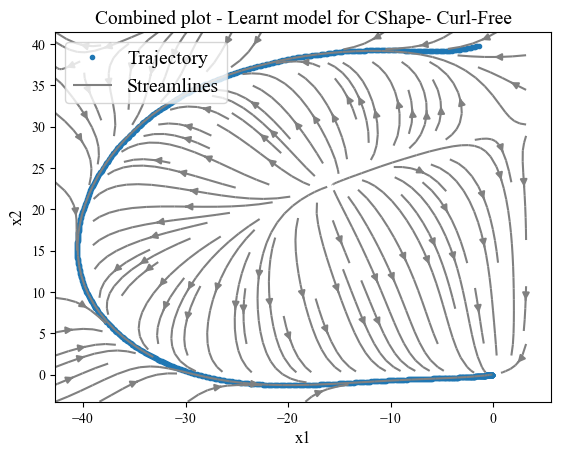

In [13]:
fig_learntmodel = plt.figure()
plt.title('Combined plot - Learnt model for ' + name_of_dataset + '- Curl-Free', fontsize=14)
plt.plot(data_series[0, :], data_series[1, :], '.', linewidth=0.1)
plt.streamplot(X1, X2, u_learnt, v_learnt, density = 1.1, color ='gray')
plt.xlabel('x1', fontsize=12)
plt.ylabel('x2', fontsize=12)
plt.legend(['Trajectory', 'Streamlines'], loc = "upper left" , frameon = True , prop ={'size': 14 } )
fig_learntmodel.show()
#plt.savefig("../src/figures_plot/lasa_learnt_model.eps", format ="eps") 